# Hand Written Digit Recognition System 

In [1]:
#import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.data import random_split


# Importing torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torchvision.utils import make_grid

#import bokeh
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d

#imort numpy
import numpy as np

#import matplotlib
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import *

# Warnings
import warnings
warnings.filterwarnings('ignore')

#### Train Dataset and Test Dataset

In [2]:
# Loading Dataset
train_set = dsets.MNIST(root='./data', 
                        train=True, 
                        transform= transforms.ToTensor(),
                        download=True)

test_set = dsets.MNIST(root='./data',
                        train=False,
                        transform= transforms.ToTensor())

In [3]:
val_size = 10000

train_set, validation_set = random_split(train_set,
                        [len(train_set) - val_size, val_size])

#### Checking the number of them in Train and Validation Dataset

In [4]:
print('Train Dataset :', len(train_set), "\nValidation Dataset:" ,len(validation_set))

Train Dataset : 50000 
Validation Dataset: 10000


### Making Dataset Iterable

In [5]:
batch_size = 100

In [6]:
# Train Loader
train_loader = DataLoader(dataset=train_set,
                          batch_size= batch_size,
                          num_workers=2,
                          pin_memory=True,
                          shuffle=True)
# Validation Loader
val_loader = DataLoader(dataset = validation_set,
                        batch_size = batch_size*2,
                        num_workers=2,
                        pin_memory=True)

# Test Loader
test_loader = DataLoader(dataset=test_set,
                         batch_size= batch_size,
                         num_workers=2,
                         pin_memory=True,
                         shuffle=False)

Shape of Images: torch.Size([100, 1, 28, 28])


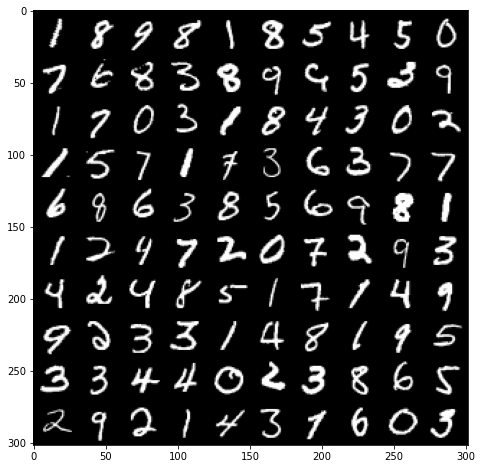

In [7]:
# Checking the data
for images, labels in train_loader:
    print('Shape of Images:', images.shape)
    plt.figure(figsize=(16,8))
    plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))
    break

In [8]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__() 
        # Convolution 1  
        self.cnn1 = nn.Conv2d(in_channels=1,
                            out_channels= 32,
                            kernel_size=5,
                            stride=1,
                            padding=2)
        self.relu1 = nn.ReLU()
    
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=32,
                            out_channels=64,
                            kernel_size=5,
                            stride=1,
                            padding=2)
    
        self.relu2 = nn.ReLU()
        
        # Max pool 2  
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
      
        # Fully connected 1   
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        nn.init.xavier_normal_(self.fc1.weight)
        
        # Fully connected 2
        self.fc2 = nn.Linear(1000, 10)
        
        # Glorot Initialization
        nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        # Max pool 1
        out = self.maxpool1(out)
       
        # Convolution 2
        out = self.cnn2(out)
        out = self.relu2(out)
        # Max pool 2  
        out = self.maxpool2(out)
        # Reshape
        out = out.reshape(out.size(0), -1)
        # Linear function
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
    def training_step(self, batch):
        images =  batch[0]
        labels = batch[1]
        out = self(images)
        loss = Loss(out, labels)
        acc = accuracy(out, labels) 
        return loss,{'Training_Loss': loss, 'Training_Accuracy': acc}

    def validation_step(self, batch):
        images =  batch[0]
        labels = batch[1]
        out = self(images)                   
        loss = Loss(out, labels)
        # Accuracy
        acc = accuracy(out, labels)      
        return {'Validation_Loss': loss, 'Validation_Accuracy': acc}
    
    def test_step(self,batch):
        images =  batch[0]
        labels = batch[1]
        out = self(images)  
        # Loss
        loss = Loss(out, labels)
        # Accuracy
        acc = accuracy(out, labels)      
        return {'Test_Loss': loss, 'Test_Accuracy': acc}
    
    def training_epoch_end(self, outputs):
        batch_losses = [x['Training_Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['Training_Accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() 
        return {'Training_Loss': epoch_loss.item(), 'Training_Accuracy': epoch_acc.item()}

    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['Validation_Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['Validation_Accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() 
        return {'Validation_Loss': epoch_loss.item(), 'Validation_Accuracy': epoch_acc.item()}

    def test_epoch_end(self, outputs):
        batch_losses = [x['Test_Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['Test_Accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() 
        return {'Test_Loss': epoch_loss.item(), 'Test_Accuracy': epoch_acc.item()}

    def epoch_end(self, epoch, result_train,result_val,result_test):
        print("Training_Loss: {:.4f}, Training_Accuracy: {:.4f}".format(result_train['Training_Loss'], result_train['Training_Accuracy']))
        print("Validation_Loss: {:.4f}, Validation_Accuracy: {:.4f}".format(result_val['Validation_Loss'], result_val['Validation_Accuracy']))
        print("Test_Loss: {:.4f}, Test_Accuracy: {:.4f}".format(result_test['Test_Loss'], result_test['Test_Accuracy']))
        

In [9]:
# Instanntiate Model Class
model = CNNModel()

#### Loss fucntion is Cross Entropy and Adjusting the Learning rate for every 10 epochs

In [10]:
# Check for GPU availability
if torch.cuda.is_available():
    model.cuda()
    
# Instantiate Loss Class
Loss = nn.CrossEntropyLoss()

# Instantiate Optimizer class
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum = 0.9)

# Adjusting the learning rate for every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

#### Functions for Accuracy and Evaluation

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate_test(model,test_loader):
    outputs = [model.test_step(batch) for batch in test_loader]
    return model.test_epoch_end(outputs)


#### Train the Model and Get the Loss and Accuracy for Test and validation Dataset

In [12]:
# Train the Model
list_fit_val,list_fit_test,list_fit_train = [],[],[]
# Number of Epochs
n_epochs = 12
for epoch in range(n_epochs):
    print("#"*55)
    print('Epoch:', epoch,'Learning rate:', scheduler.get_lr())
    print("-"*55)
    output_list = []
    for batch in train_loader:
        loss, outp = model.training_step(batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        output_list.append(outp)
    result_train = model.training_epoch_end(output_list)
    result_val = evaluate(model, val_loader)
    result_test = evaluate_test(model,test_loader)
    model.epoch_end(epoch,result_train, result_val,result_test)
    list_fit_val.append(result_val)
    list_fit_test.append(result_test)
    list_fit_train.append(result_train)
    scheduler.step()

#######################################################
Epoch: 0 Learning rate: [0.05]
-------------------------------------------------------
Training_Loss: 0.1475, Training_Accuracy: 0.9558
Validation_Loss: 0.0530, Validation_Accuracy: 0.9826
Test_Loss: 0.0405, Test_Accuracy: 0.9866
#######################################################
Epoch: 1 Learning rate: [0.05]
-------------------------------------------------------
Training_Loss: 0.0408, Training_Accuracy: 0.9877
Validation_Loss: 0.0406, Validation_Accuracy: 0.9861
Test_Loss: 0.0324, Test_Accuracy: 0.9903
#######################################################
Epoch: 2 Learning rate: [0.05]
-------------------------------------------------------
Training_Loss: 0.0299, Training_Accuracy: 0.9905
Validation_Loss: 0.0464, Validation_Accuracy: 0.9855
Test_Loss: 0.0308, Test_Accuracy: 0.9900
#######################################################
Epoch: 3 Learning rate: [0.05]
-------------------------------------------------------

### Plotting the Learning Curves and checking the Accuracies

In [13]:
# Seperating the Validation Loss and Validation Accuracy as individual Lists
plots_loss = []
plots_acccuracy = []
losses = [x['Training_Loss'] for x in list_fit_train]
accuracies = [x['Training_Accuracy'] for x in list_fit_train]
plots_loss.append(losses)
plots_acccuracy.append(accuracies)
losses = [x['Validation_Loss'] for x in list_fit_val]
accuracies = [x['Validation_Accuracy'] for x in list_fit_val]
plots_loss.append(losses)
plots_acccuracy.append(accuracies)

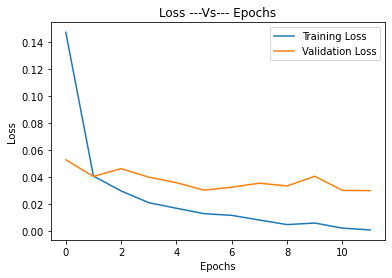

In [20]:
plt.plot(plots_loss[0],label = 'Training Loss')
plt.plot(plots_loss[1] ,label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss ---Vs--- Epochs')
plt.legend()
plt.show()

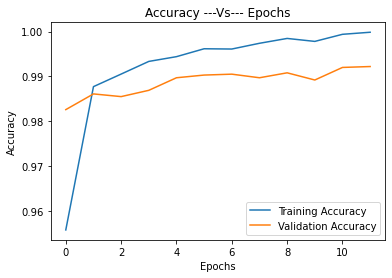

In [21]:
plt.plot(plots_acccuracy[0], label = 'Training Accuracy')
plt.plot(plots_acccuracy[1], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy ---Vs--- Epochs")
plt.legend()
plt.show()

#### Question : Test this baseline system with the testing data and report the accuracy and show a confusion matrix. 

## Confusiuon Matrix

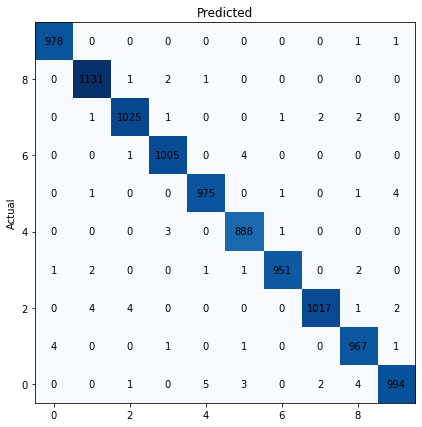

*******************************************************
Accuracy of Testing Data: 0.993100
*******************************************************


In [19]:
model.eval()
actual,pred = [],[]
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        predic = output.argmax(dim=1, keepdim=True)
        actual.extend(target.view_as(predic))
        pred.extend(predic)
    actual = [i.item() for i in actual]
    pred = [i.item() for i in pred]
mat = confusion_matrix(actual, pred)

n_classes = np.unique(actual).shape[0]
plt.figure(figsize=(7,7))
plt.imshow(mat, extent=[-0.5, n_classes-1+0.5, -0.5, n_classes-1+0.5], origin="upper",cmap = 'Blues')
plt.ylabel("Actual")
plt.title("Predicted")
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        plt.text(i, j, mat[mat.shape[0]-j-1,i], ha="center", va="center")
plt.show()
print("*"*55)
print('Accuracy of Testing Data: %f' % accuracy_score(actual, pred))
print("*"*55)


# Summary

- The loss seems to have reached a global minimum after the tenth epoch. As a result, even though the learning rate varies, it remains constant.
- In the confusion matrix, we can see that "99.31" has been predicted correctly which are shown as true positibves.
- We can also see from the confusion matrix that the false positives are of few number which means that our model has predicted almost all the images correctly.
- The testing set performed better compared to the validation set which can be observed from the learning curves
- From the plots of learning curves of Training,validation and testing sets it can be clearly seen that Loss got reduced and there is increase in accuracy
